In [1]:
!pip install sweetviz
!pip install plotly
!pip install ydata_profiling
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 73.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=16fd8d3d7310d2023a251d1a9eeb0108d24a7401434792779fc2f04b4a37efa0
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


In [2]:
# Importar librerías
## EDA
import pandas as pd
import numpy as np
import sweetviz as sv
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Modelamiento
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform

# a. Análisis Exploratorio

In [4]:
# Cargar datos
clientes = pd.read_excel('/content/drive/MyDrive/DSA/clientes_final.xlsx')
ventas = pd.read_excel('/content/drive/MyDrive/DSA/venta_final.xlsx')

## Variables

In [ ]:
# Exploración inicial
print("\nClientes DataFrame Info:")
print(clientes.info())

print("\nVentas DataFrame Info:")
print(ventas.info())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas - Clientes:")
print(clientes.describe())

print("\nEstadísticas descriptivas - Ventas:")


Clientes DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3369 entries, 0 to 3368
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Cliente   3369 non-null   object
 1   Gerencia  3369 non-null   object
 2   subcanal  3369 non-null   object
dtypes: object(3)
memory usage: 79.1+ KB
None

Ventas DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140611 entries, 0 to 140610
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Cliente  140611 non-null  object 
 1   ym       140611 non-null  int64  
 2   brand    140611 non-null  object 
 3   segment  140611 non-null  object 
 4   vol      140611 non-null  float64
 5   nr       140611 non-null  float64
 6   desc     140611 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 7.5+ MB
None

Estadísticas descriptivas - Clientes:
       Cliente   Gerencia  subcanal
count

In [ ]:
print(ventas.drop_duplicates().shape)
print(clientes.drop_duplicates().shape)

(120123, 7)
(2861, 3)


Se asume que los registros deben ser únicos en cada base, por lo tanto, que tanto en la base de clientes como en la de ventas solo existe un registro por cliente y por venta (con la misma información)

In [ ]:
ventas.drop_duplicates(inplace=True)
clientes.drop_duplicates(inplace=True)

## Clientes

In [ ]:
ventas['porc_desc'] = abs(ventas['desc'])/(abs(ventas['desc'])+ ventas['nr'])
ventas['porc_desc_sin_0'] = np.where(ventas['porc_desc'] == 0, np.nan, ventas['porc_desc'])

In [ ]:
ventas['vol_cat'] = np.where((ventas['vol'] > 1)&(ventas['vol'] <= 1.5), '(1-1.5]',
                           np.where((ventas['vol'] > 1.5)&(ventas['vol'] <= 2.5), '(1.5-2.5]',
                                    np.where((ventas['vol'] > 2.5)&(ventas['vol'] <= 9.5), '(2.5-9.5]', '>9.5')))
ventas['nr_cat'] = np.where((ventas['nr'] == 0), '0',
                           np.where((ventas['nr'] > 0)&(ventas['nr'] <= 2600000), '(0-2.6M]',
                                    np.where((ventas['nr'] > 2600000)&(ventas['nr'] <= 3500000), '(2.6M-3.5M]',
                                             np.where((ventas['nr'] > 3500000)&(ventas['nr'] <= 34000000), '(3.5M-34M]', '>34M'))))
ventas['porc_desc_cat'] = np.where((ventas['porc_desc'] == 0), '0%',
                                 np.where((ventas['porc_desc'] > 0)&(ventas['porc_desc'] <= 0.2), '(0%-20%]',
                                          np.where((ventas['porc_desc'] > 0.2)&(ventas['porc_desc'] <= 0.4), '(20%-40%]',
                                                   np.where((ventas['porc_desc'] > 0.4)&(ventas['porc_desc'] <= 0.6), '(40%-60%]',
                                                            np.where((ventas['porc_desc'] > 0.6)&(ventas['porc_desc'] <= 0.8), '(60%-80%]',
                                                                     np.where((ventas['porc_desc'] > 0.8)&(ventas['porc_desc'] <= 1), '(80%-100%]', 'No_Aplica'))))))

In [ ]:
abt = pd.merge(ventas, clientes, on='Cliente', how='left')

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
abt.groupby(['Gerencia', 'subcanal']).agg({'Cliente': 'nunique',
                                           'porc_desc': ['min', 'max', 'mean'],
                                           'nr': ['min', 'max', 'mean', 'sum'],
                                           'vol': ['min', 'max', 'mean', 'sum']})

Cliente porc_desc                         nr  \
                       nunique       min    max   mean          min   
Gerencia  subcanal                                                    
Gerencia1 tiendita         426    0.0000 1.0000 0.0571       0.0000   
Gerencia2 tiendita         668    0.0000 1.0000 0.0584       0.0000   
Gerencia3 tiendita         428    0.0000 1.0000 0.0580       0.0000   
Gerencia4 tiendita         289    0.0000 1.0000 0.0685       0.0000   
Gerencia5 tiendita         271    0.0000 1.0000 0.0774       0.0000   
Gerencia6 tiendita         523    0.0000 1.0000 0.0692       0.0000   
Gerencia7 tiendita         239    0.0000 1.0000 0.0738       0.0000   
Gerencia8 tiendita          11    0.0000 1.0000 0.0292       0.0000   
Gerencia9 supermercado       1    0.0000 0.0000 0.0000 1956098.3333   
          tiendita           5    0.0000 1.0000 0.0461       0.0000   

                                                                           \
                                    max           mean                sum   
Gerencia  subcanal                                                          
Gerencia1 tiendita      4547396868.3333  49016286.5548  832247529413.3334   
Gerencia2 tiendita     12575360147.7778  26509185.0423  724628573130.5555   
Gerencia3 tiendita      2109322142.2222  38012505.7361  797996532918.3334   
Gerencia4 tiendita      1084462321.6667  31107255.2904  301460411018.8889   
Gerencia5 tiendita      4569306481.1111  25294101.9884  208752223710.0000   
Gerencia6 tiendita      5271868068.8889  48247869.4043 1234855969533.3333   
Gerencia7 tiendita      4976832738.3333  46752277.8993  480286150860.0000   
Gerencia8 tiendita     24477788493.3333 402129143.6232  269024397083.8888   
Gerencia9 supermercado  1433813324.4444 149498261.0000    4484947830.0000   
          tiendita       524905115.0000  58827494.3555   18001213272.7778   

                          vol                               
                          min       max    mean        sum  
Gerencia  subcanal                                          
Gerencia1 tiendita     1.3000  274.4340  3.6778 62445.9920  
Gerencia2 tiendita     1.3000 1163.9230  2.8172 77008.9500  
Gerencia3 tiendita     1.3000  120.1000  3.0044 63070.7150  
Gerencia4 tiendita     1.3000   38.2270  2.6964 26131.1020  
Gerencia5 tiendita     1.3000  256.4230  2.4714 20396.2430  
Gerencia6 tiendita     1.3130  237.7120  3.6189 92622.0760  
Gerencia7 tiendita     1.3000  231.0760  3.5855 36833.5470  
Gerencia8 tiendita     1.3000 1174.2980 19.5772 13097.1410  
Gerencia9 supermercado 1.3650   48.6620  6.5621   196.8620  
          tiendita     1.3590   13.1800  3.2698  1000.5630

## Insights

In [ ]:
report =  sv.analyze(abt)
report.show_html('EDA_Fuentes.html')

                                             |          | [  0%]   00:00 -> (? left)

Report EDA_Fuentes.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
profile = ProfileReport(abt, title="EDA Fuentes Clientes & Ventas", minimal=True)
profile.to_file("EDA_Fuentes_2.html")

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Gráfico de dispersión productos vendidos vs. ganancia
fig = px.scatter(abt, x='vol', y='nr', color='porc_desc_cat',
                 color_continuous_scale='viridis',
                 title='Gráfica de Cantidad de productos vendidos vs. Ganancia, por grupo de descuento',
                 labels={'vol': 'Cantidad de productos vendidos',
                         'nr': 'Ganancia',
                         'porc_desc_cat': 'Porcentaje de descuento'})

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
abt.groupby(['Cliente', 'ym']).agg({'brand': 'count'}) #Hay más de un registro por cliente y mes

brand
Cliente ym           
cte1    202301      1
        202302      2
        202303      2
        202304      2
        202305      2
...               ...
cte999  202303      4
        202304      4
        202305      3
        202306      4
        202307      2

[33782 rows x 1 columns]

In [ ]:
suma_nr = abt.groupby(['brand'])['nr'].sum()
suma_vol = abt.groupby(['brand'])['vol'].sum()
ganan_x_und = pd.DataFrame({
    'suma_nr': suma_nr,
    'suma_vol': suma_vol
 })
ganan_x_und['ganancia_x_und'] = ganan_x_und['suma_nr'] / ganan_x_und['suma_vol']

In [ ]:
# Proporción de ventas por marca
pd.concat([(100*abt.groupby(['brand']).agg({'Cliente': 'count'})/len(abt)).sort_values(by='Cliente'),
           (abt.groupby(['brand']).agg({'Cliente': 'count'})),
           ganan_x_und['ganancia_x_und']], axis=1)

,Cliente,Cliente,ganancia_x_und
brand,,,
Marca8,1.37275959,1649,6238037.17866561
Marca9,2.64478909,3177,6661178.99352149
Marca4,2.86955870,3447,7917911.38615587
Marca7,10.77062677,12938,10958149.03839460
Marca6,11.88947995,14282,9393435.26147100
Marca5,13.64434788,16390,15108624.18530451
Marca3,14.28452503,17159,8276058.83568700
Marca2,19.31103952,23197,11686868.17396964
Marca1,23.21287347,27884,15131583.75503718


In [ ]:
# Proporción de ventas por segmento
pd.concat([(100*abt.groupby(['segment']).agg({'Cliente': 'count'})/len(abt)).sort_values(by='Cliente'),
           (abt.groupby(['segment']).agg({'Cliente': 'count'})).sort_values(by='Cliente')], axis=1)

,Cliente,Cliente
segment,,
Value,2.869559,3447
Premium,11.881155,14272
Globales,27.043114,32485
Core,58.206172,69919


# b. Modelo de venta - Marca1

In [ ]:
# Marca elegida: Marca1
abt_final = abt[['Gerencia', 'subcanal', 'desc', 'brand', 'ym', 'Cliente', 'vol']]
abt_final['target'] = np.where(abt['brand'] == 'Marca1', 1, 0)
abt_final

<ipython-input-100-63261ab602ba>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Gerencia,subcanal,desc,brand,ym,Cliente,vol,target
0,Gerencia1,tiendita,0.000000e+00,Marca1,202301,cte1,4.877,1
1,Gerencia1,tiendita,0.000000e+00,Marca1,202302,cte1,2.519,1
2,Gerencia1,tiendita,-1.863603e+06,Marca2,202302,cte1,2.092,0
3,Gerencia1,tiendita,0.000000e+00,Marca1,202303,cte1,3.633,1
4,Gerencia1,tiendita,0.000000e+00,Marca2,202303,cte1,1.696,0
...,...,...,...,...,...,...,...,...
120118,Gerencia5,tiendita,0.000000e+00,Marca7,202406,cte2859,1.854,0
120119,Gerencia5,tiendita,0.000000e+00,Marca2,202406,cte2859,1.854,0
120120,Gerencia2,tiendita,0.000000e+00,Marca2,202406,cte2860,1.430,0
120121,Gerencia1,tiendita,0.000000e+00,Marca1,202406,cte2861,1.399,1


In [ ]:
# Creación de variable de volumen vendido anteriormente al cliente de esta misma marca
abt_final['ym'] = pd.to_datetime(abt_final['ym'], format='%Y%m')
df_marca1 = abt_final[abt_final['brand'] == 'Marca1'].copy()
df_marca1 = df_marca1.sort_values(by=['Cliente', 'ym'])
df_marca1['vol_vendido_antes_m1'] = df_marca1.groupby('Cliente')['vol'].cumsum() - df_marca1['vol']
result = abt_final.merge(df_marca1[['Cliente', 'ym', 'vol_vendido_antes_m1']],
                         on=['Cliente', 'ym'],
                         how='left')
result['vol_vendido_antes_m1'] = result['vol_vendido_antes_m1'].fillna(0)

# Creación del descuento dado al cliente en los periodos anteriores
df_desc = result.loc[result['brand'] == 'Marca1']
df_desc['abs_desc'] = abs(df_desc['desc'])
df_desc = df_desc.sort_values(by=['Cliente', 'ym'])
df_desc['desc_antes_m1'] = df_desc.groupby('Cliente')['abs_desc'].cumsum() - df_desc['abs_desc']
result2 = result.merge(df_desc[['Cliente', 'ym', 'desc_antes_m1']],
                         on=['Cliente', 'ym'],
                         how='left')
result2['desc_antes_m1'] = result2['desc_antes_m1'].fillna(0)

<ipython-input-101-94010af3c3e4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-101-94010af3c3e4>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Se agrupan las ventas por cliente y fecha, para modelar si un cliente comprará en un mes la marca 1

In [ ]:
abt_modelo = result2.groupby(['Cliente', 'ym', 'Gerencia', 'subcanal']).agg({'desc_antes_m1': 'max',
                                        'vol_vendido_antes_m1' : 'max',
                                        'target' : 'max'}).reset_index(drop=False).drop(columns=['Cliente',
                                                                                                 'ym'])
abt_modelo.describe(include='all')

,Gerencia,subcanal,desc_antes_m1,vol_vendido_antes_m1,target
count,33782,33782,3.378200e+04,33782.000000,33782.000000
unique,9,2,NaN,NaN,NaN
top,Gerencia2,tiendita,NaN,NaN,NaN
freq,8531,33774,NaN,NaN,NaN
mean,NaN,NaN,8.312309e+06,31.978163,0.825410
std,NaN,NaN,4.038861e+07,106.974834,0.379622
min,NaN,NaN,0.000000e+00,0.000000,0.000000
25%,NaN,NaN,0.000000e+00,0.000000,1.000000
50%,NaN,NaN,1.284356e+05,11.700000,1.000000
75%,NaN,NaN,3.868823e+06,32.629750,1.000000


In [ ]:
X = abt_modelo[['desc_antes_m1', 'vol_vendido_antes_m1', 'Gerencia', 'subcanal']]
y = abt_modelo['target']
numeric_features = ['desc_antes_m1', 'vol_vendido_antes_m1']
categorical_features = ['Gerencia', 'subcanal']

numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_processed =preprocessor.fit_transform(X)

### Regresión Logística

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=0)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[   0 1193]
 [   0 5564]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1193
           1       0.82      1.00      0.90      5564

    accuracy                           0.82      6757
   macro avg       0.41      0.50      0.45      6757
weighted avg       0.68      0.82      0.74      6757



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



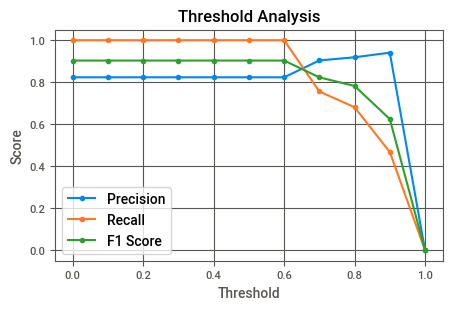

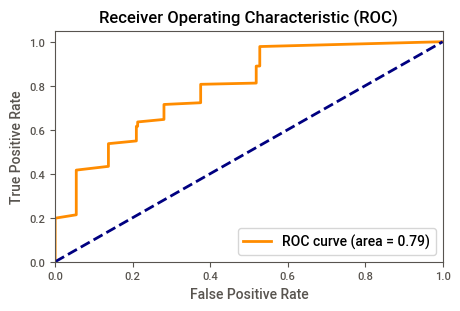

In [ ]:
# Obtener probabilidades de predicción
y_probs = model.predict_proba(X_test)[:, 1]

# Definir una serie de umbrales
thresholds = np.arange(0.0, 1.1, 0.1)

# Inicializar listas para almacenar métricas
precisions = []
recalls = []
f1_scores = []

# Evaluar el modelo para cada umbral
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)

    # Calcular métricas
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Graficar resultados
plt.figure(figsize=(5, 3))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Analysis')
plt.legend()
plt.grid(True)
plt.show()

# Graficar la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
for threshold in [0.7, 0.8, 0.9]:
  y_probs = model.predict_proba(X_test)[:, 1]
  y_pred = (y_probs >= threshold).astype(int)
  conf_matrix = confusion_matrix(y_test, y_pred)
  print(conf_matrix)
  print(classification_report(y_test, y_pred))

[[ 745  448]
 [1358 4206]]
              precision    recall  f1-score   support

           0       0.35      0.62      0.45      1193
           1       0.90      0.76      0.82      5564

    accuracy                           0.73      6757
   macro avg       0.63      0.69      0.64      6757
weighted avg       0.81      0.73      0.76      6757

[[ 858  335]
 [1775 3789]]
              precision    recall  f1-score   support

           0       0.33      0.72      0.45      1193
           1       0.92      0.68      0.78      5564

    accuracy                           0.69      6757
   macro avg       0.62      0.70      0.62      6757
weighted avg       0.81      0.69      0.72      6757

[[1029  164]
 [2963 2601]]
              precision    recall  f1-score   support

           0       0.26      0.86      0.40      1193
           1       0.94      0.47      0.62      5564

    accuracy                           0.54      6757
   macro avg       0.60      0.67      0.51    

### Importancia de variables

In [ ]:
feature_names = (numeric_features +
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))
coef = model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                  Feature  Coefficient
1    vol_vendido_antes_m1    13.168801
0           desc_antes_m1     5.369600
7      Gerencia_Gerencia6     1.139391
2      Gerencia_Gerencia1     0.649790
4      Gerencia_Gerencia3     0.569530
12      subcanal_tiendita     0.385330
10     Gerencia_Gerencia9     0.225188
5      Gerencia_Gerencia4     0.206904
6      Gerencia_Gerencia5    -0.225314
11  subcanal_supermercado    -0.319171
8      Gerencia_Gerencia7    -0.787441
9      Gerencia_Gerencia8    -0.842879
3      Gerencia_Gerencia2    -0.869011


## Catboost

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'
)
X_processed = preprocessor.fit_transform(X[numeric_features])
X_categorical = X[categorical_features]
X_final = np.hstack((X_processed, X_categorical))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=0)

# Ajustar el modelo CatBoost
model = CatBoostClassifier(cat_features=[2, 3])
model.fit(X_train, y_train, cat_features=[2, 3], verbose=200)

# Predicciones y evaluación
y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Learning rate set to 0.042102
0:	learn: 0.5753897	total: 52.6ms	remaining: 52.6s
200:	learn: 0.1435450	total: 8.91s	remaining: 35.4s
400:	learn: 0.1431972	total: 12.7s	remaining: 18.9s
600:	learn: 0.1430882	total: 15.8s	remaining: 10.5s
800:	learn: 0.1430667	total: 19.7s	remaining: 4.89s
999:	learn: 0.1430657	total: 23.9s	remaining: 0us
Confusion Matrix:
[[1128   65]
 [ 428 5136]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.95      0.82      1193
           1       0.99      0.92      0.95      5564

    accuracy                           0.93      6757
   macro avg       0.86      0.93      0.89      6757
weighted avg       0.94      0.93      0.93      6757



### Importancia de variables


Feature Importance:
                Feature  Importance
1  vol_vendido_antes_m1   94.028808
2              Gerencia    3.810595
0         desc_antes_m1    2.154702
3              subcanal    0.005896


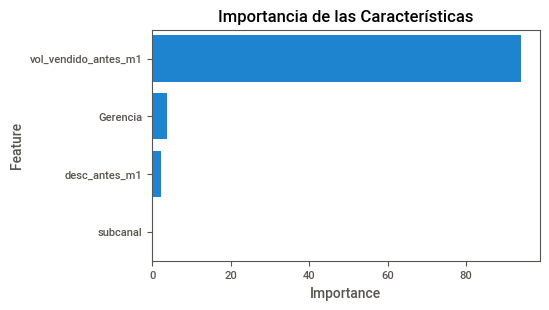

In [ ]:
feature_importances = model.get_feature_importance()
feature_names = (numeric_features +
                 list(X_categorical.columns))

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

plt.figure(figsize=(5, 3))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()